# Hexagon grid by city

Create an H3 hexagon grid by metropolitan area at resolutions 8, 9, 10 and 11, identifying urban and rural areas.

## Import libraries

In [1]:
import os
import sys

import geopandas as gpd
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)
    import aup

/home/edgaregurrola/anaconda3/envs/odc/lib/python3.10/site-packages/geopandas/_compat.py:123: UserWarning: The Shapely GEOS version (3.10.3-CAPI-1.16.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.1-CAPI-1.16.0). Conversions between both will be slow.
  warnings.warn(
/home/edgaregurrola/.local/lib/python3.10/site-packages/requests/__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (5.1.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  warnings.warn(


2023-11-10 11:30:09 Configured OSMnx 1.1.2
2023-11-10 11:30:09 HTTP response caching is on


## Download data

### Donwloand cities names for analysis

In [2]:
schema = 'metropolis'
table = 'metro_gdf_2020'

query = f"SELECT DISTINCT city from {schema}.{table}"

city_names = aup.df_from_query(query)
print(city_names.shape)
city_names.head(4)

(71, 1)


,city
0,Villahermosa
1,Matamoros
2,Chetumal
3,Cordoba


## Download mun_gdf

In [3]:
schema = 'metropolis'
table = 'metro_gdf_2020'

city = 'Los Mochis'

query = f"SELECT * FROM {schema}.{table} WHERE \"city\" = \'{city}\'"

mun_gdf = aup.gdf_from_query(query)
print(mun_gdf.shape)
mun_gdf.head(2)

(1, 6)


,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,geometry,city
0,25001,25,001,Ahome,"POLYGON ((-109.00405 26.40009, -109.00385 26.4...",Los Mochis


### Download AGEB data

In [4]:
schema = 'censoageb'
table = 'censoageb_2020'

ageb_gdf = gpd.GeoDataFrame()

for cvegeo in mun_gdf.CVEGEO.unique():
    query = f"SELECT cve_geo,pobtot,geometry FROM {schema}.{table} WHERE \"cve_geo\" LIKE \'{cvegeo}%%\'"
    ageb_gdf = pd.concat([ageb_gdf, aup.gdf_from_query(query)],
                        ignore_index = True, axis = 0)
print(ageb_gdf.shape)
ageb_gdf.head(4)

(346, 3)


,cve_geo,pobtot,geometry
0,2500100014918,0,"POLYGON ((-109.02293 25.80837, -109.02341 25.8..."
1,2500100704956,35,"POLYGON ((-109.17988 25.91875, -109.17997 25.9..."
2,2500100013943,56,"POLYGON ((-109.02129 25.75944, -109.02264 25.7..."
3,2500101151650,2658,"POLYGON ((-108.89619 25.88180, -108.89705 25.8..."


## Merge GeoDataFrames

In [5]:
mun_buff = mun_gdf.to_crs("EPSG:6372").buffer(500)
mun_buff = mun_buff.to_crs("EPSG:4326")
mun_buff = gpd.GeoDataFrame(geometry=mun_buff).dissolve()
mun_buff

,geometry
0,"POLYGON ((-109.45062 25.95292, -109.45076 25.9..."


<AxesSubplot: >

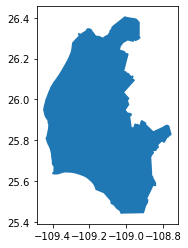

In [6]:
mun_buff.plot()

In [7]:
ageb_buff = ageb_gdf.to_crs("EPSG:6372").buffer(500)
ageb_buff = ageb_buff.to_crs("EPSG:4326")
ageb_buff = gpd.GeoDataFrame(geometry=ageb_buff).dissolve()
ageb_buff

,geometry
0,"MULTIPOLYGON (((-109.06737 25.59063, -109.0672..."


<AxesSubplot: >

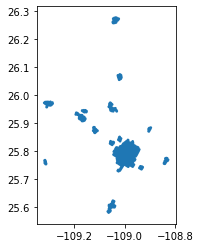

In [8]:
ageb_buff.plot()

<AxesSubplot: >

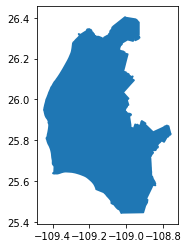

In [9]:
gdf_merge = pd.concat([ageb_buff, mun_buff])
gdf_merge = gdf_merge.dissolve()
gdf_merge.plot()

## Create hexgrid

In [10]:
hex_gdf = aup.create_hexgrid(gdf_merge, 8)
print(hex_gdf.shape)
hex_gdf.head(4)

(4720, 2)


,hex_id_8,geometry
0,88480ed0b7fffff,"POLYGON ((-108.99111 25.86833, -108.98649 25.8..."
1,88480e8345fffff,"POLYGON ((-109.38207 25.81890, -109.37747 25.8..."
2,884803a691fffff,"POLYGON ((-108.88832 25.69797, -108.88371 25.7..."
3,8848017999fffff,"POLYGON ((-108.97205 25.51228, -108.96745 25.5..."


<AxesSubplot: >

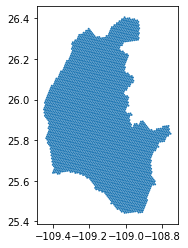

In [11]:
hex_gdf.plot()

## Spatial join

### Centroid to municipality

In [12]:
hex_cnt = gpd.GeoDataFrame(geometry=hex_gdf.representative_point(), crs="EPSG:4326")
hex_cnt = hex_cnt.merge(hex_gdf[['hex_id_8']],  left_index=True, right_index=True)
print(hex_cnt.shape)
hex_cnt.head(2)

(4720, 2)


,geometry,hex_id_8
0,POINT (-108.99191 25.87353),88480ed0b7fffff
1,POINT (-109.38289 25.82410),88480e8345fffff


Test merge

<AxesSubplot: >

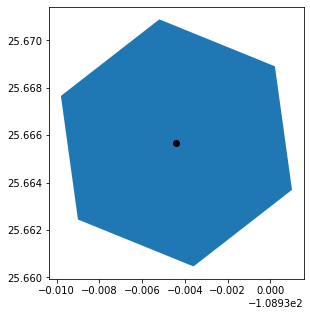

In [13]:
fig,ax = plt.subplots(figsize=(5,5))
hex_gdf.loc[hex_gdf.hex_id_8=='88480169c7fffff'].plot(ax=ax)
hex_cnt.loc[hex_cnt.hex_id_8=='88480169c7fffff'].plot(color='black',ax=ax)


Intersection

In [14]:
cnt_join = hex_cnt.sjoin(mun_gdf).drop(columns='index_right')
print(cnt_join.shape)
cnt_join.head(4)

(4498, 7)


,geometry,hex_id_8,CVEGEO,CVE_ENT,CVE_MUN,NOMGEO,city
0,POINT (-108.99191 25.87353),88480ed0b7fffff,25001,25,001,Ahome,Los Mochis
1,POINT (-109.38289 25.82410),88480e8345fffff,25001,25,001,Ahome,Los Mochis
2,POINT (-108.88911 25.70318),884803a691fffff,25001,25,001,Ahome,Los Mochis
3,POINT (-108.97285 25.51749),8848017999fffff,25001,25,001,Ahome,Los Mochis


Centroid to polygon join

In [15]:
hex_merge = hex_gdf.merge(cnt_join[['hex_id_8','CVEGEO','NOMGEO','city']],
             on='hex_id_8', how='outer')
print(hex_merge.shape)
hex_merge.head(4)

(4720, 5)


,hex_id_8,geometry,CVEGEO,NOMGEO,city
0,88480ed0b7fffff,"POLYGON ((-108.99111 25.86833, -108.98649 25.8...",25001,Ahome,Los Mochis
1,88480e8345fffff,"POLYGON ((-109.38207 25.81890, -109.37747 25.8...",25001,Ahome,Los Mochis
2,884803a691fffff,"POLYGON ((-108.88832 25.69797, -108.88371 25.7...",25001,Ahome,Los Mochis
3,8848017999fffff,"POLYGON ((-108.97205 25.51228, -108.96745 25.5...",25001,Ahome,Los Mochis


### AGEB Intersection

In [16]:
ageb_join = ageb_gdf.sjoin(hex_merge).drop(columns='index_right')

Test

In [17]:
ageb_gdf.loc[ageb_gdf.cve_geo.isin(list(ageb_join.cve_geo.unique()))].pobtot.sum()

372200

In [18]:
ageb_gdf.pobtot.sum()

372200

In [19]:
ageb_gdf.shape

(346, 3)

In [20]:
ageb_gdf.loc[ageb_gdf.cve_geo.isin(list(ageb_join.cve_geo.unique()))].shape

(346, 3)

<AxesSubplot: >

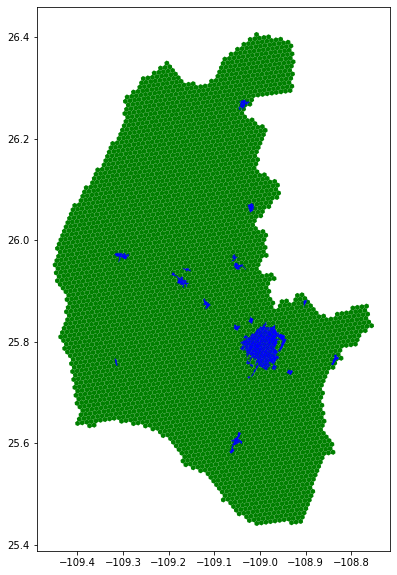

In [21]:
fig,ax = plt.subplots(figsize=(10,10))
hex_merge.plot(color='green',ax=ax)
ageb_gdf.plot(color='blue',ax=ax)


Define urban

In [22]:
hex_list = list(ageb_join.hex_id_8.unique())
hex_merge.loc[:,'type'] = 'rural'
hex_merge.loc[hex_merge.hex_id_8.isin(hex_list),'type'] = 'urban'
print(hex_merge.shape)
hex_merge.head(4)

(4720, 6)


,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
0,88480ed0b7fffff,"POLYGON ((-108.99111 25.86833, -108.98649 25.8...",25001,Ahome,Los Mochis,rural
1,88480e8345fffff,"POLYGON ((-109.38207 25.81890, -109.37747 25.8...",25001,Ahome,Los Mochis,rural
2,884803a691fffff,"POLYGON ((-108.88832 25.69797, -108.88371 25.7...",25001,Ahome,Los Mochis,rural
3,8848017999fffff,"POLYGON ((-108.97205 25.51228, -108.96745 25.5...",25001,Ahome,Los Mochis,rural


<AxesSubplot: >

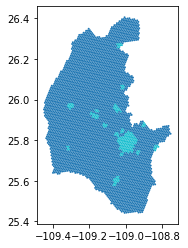

In [23]:
hex_merge.plot('type')

## Fill missing data

In [24]:
hex_merge.loc[(hex_merge.CVEGEO.isna())&(hex_merge['type']=='urban')]

,hex_id_8,geometry,CVEGEO,NOMGEO,city,type
2227,884803a4a3fffff,"POLYGON ((-108.82153 25.76202, -108.81691 25.7...",NaN,NaN,NaN,urban
2872,88480e56d9fffff,"POLYGON ((-109.02135 26.26269, -109.01673 26.2...",NaN,NaN,NaN,urban
3003,88480ec34dfffff,"POLYGON ((-108.89462 25.87239, -108.89000 25.8...",NaN,NaN,NaN,urban
3254,884803a481fffff,"POLYGON ((-108.83919 25.74390, -108.83457 25.7...",NaN,NaN,NaN,urban
3456,884803a4b5fffff,"POLYGON ((-108.82773 25.76921, -108.82312 25.7...",NaN,NaN,NaN,urban
3786,884803a487fffff,"POLYGON ((-108.83537 25.75234, -108.83076 25.7...",NaN,NaN,NaN,urban
4314,88480e19e5fffff,"POLYGON ((-109.03141 26.26143, -109.02679 26.2...",NaN,NaN,NaN,urban


Fill missing data from AGEB

In [25]:
ageb_join.loc[:,'CVEGEO'] = ageb_join.cve_geo.str[:5]
ageb_join.loc[:,'city'] = city
ageb_join

,cve_geo,pobtot,geometry,hex_id_8,CVEGEO,NOMGEO,city
0,2500100014918,0,"POLYGON ((-109.02293 25.80837, -109.02341 25.8...",88480ed2b1fffff,25001,Ahome,Los Mochis
12,2500100011078,1991,"POLYGON ((-109.01360 25.80820, -109.01211 25.8...",88480ed2b1fffff,25001,Ahome,Los Mochis
13,2500100011256,1998,"POLYGON ((-109.02400 25.80814, -109.02400 25.8...",88480ed2b1fffff,25001,Ahome,Los Mochis
38,2500100014848,23,"POLYGON ((-109.02538 25.80697, -109.02554 25.8...",88480ed2b1fffff,25001,Ahome,Los Mochis
105,2500100012697,2505,"POLYGON ((-109.01786 25.80154, -109.01802 25.8...",88480ed2b1fffff,25001,Ahome,Los Mochis
...,...,...,...,...,...,...,...
325,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4a3fffff,25001,NaN,Los Mochis
325,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b1fffff,25001,Ahome,Los Mochis
325,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b5fffff,25001,NaN,Los Mochis
336,2500100013623,1015,"POLYGON ((-108.99543 25.82833, -108.99543 25.8...",88480ed089fffff,25001,Ahome,Los Mochis


Fill missing NOMGEO

In [26]:
ageb_join = ageb_join.drop(columns=['NOMGEO'])
ageb_join = ageb_join.merge(mun_gdf[['CVEGEO','NOMGEO']], on='CVEGEO')
ageb_join

,cve_geo,pobtot,geometry,hex_id_8,CVEGEO,city,NOMGEO
0,2500100014918,0,"POLYGON ((-109.02293 25.80837, -109.02341 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
1,2500100011078,1991,"POLYGON ((-109.01360 25.80820, -109.01211 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
2,2500100011256,1998,"POLYGON ((-109.02400 25.80814, -109.02400 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
3,2500100014848,23,"POLYGON ((-109.02538 25.80697, -109.02554 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
4,2500100012697,2505,"POLYGON ((-109.01786 25.80154, -109.01802 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
...,...,...,...,...,...,...,...
836,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4a3fffff,25001,Los Mochis,Ahome
837,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b1fffff,25001,Los Mochis,Ahome
838,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b5fffff,25001,Los Mochis,Ahome
839,2500100013623,1015,"POLYGON ((-108.99543 25.82833, -108.99543 25.8...",88480ed089fffff,25001,Los Mochis,Ahome


In [27]:
ageb_to_merge = ageb_join.drop_duplicates(subset='hex_id_8')
ageb_to_merge

,cve_geo,pobtot,geometry,hex_id_8,CVEGEO,city,NOMGEO
0,2500100014918,0,"POLYGON ((-109.02293 25.80837, -109.02341 25.8...",88480ed2b1fffff,25001,Los Mochis,Ahome
14,2500100704956,35,"POLYGON ((-109.17988 25.91875, -109.17997 25.9...",88480ed4d1fffff,25001,Los Mochis,Ahome
20,2500100013943,56,"POLYGON ((-109.02129 25.75944, -109.02264 25.7...",88480ed2c1fffff,25001,Los Mochis,Ahome
27,2500101151650,2658,"POLYGON ((-108.89619 25.88180, -108.89705 25.8...",88480ed1a3fffff,25001,Los Mochis,Ahome
28,2500101151650,2658,"POLYGON ((-108.89619 25.88180, -108.89705 25.8...",88480ed1a7fffff,25001,Los Mochis,Ahome
...,...,...,...,...,...,...,...
836,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4a3fffff,25001,Los Mochis,Ahome
837,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b1fffff,25001,Los Mochis,Ahome
838,2500101361006,4243,"POLYGON ((-108.83281 25.77403, -108.83236 25.7...",884803a4b5fffff,25001,Los Mochis,Ahome
839,2500100013623,1015,"POLYGON ((-108.99543 25.82833, -108.99543 25.8...",88480ed089fffff,25001,Los Mochis,Ahome


Fill missing urban data

In [28]:
hex_merge.shape

(4720, 6)

In [29]:
left_a = hex_merge.set_index('hex_id_8')
right_a = ageb_to_merge[['hex_id_8','CVEGEO','city','NOMGEO']].set_index('hex_id_8')

In [30]:
res = left_a.reindex(columns=left_a.columns.union(right_a.columns))
res.update(right_a)
res.reset_index(inplace=True)
res

,hex_id_8,CVEGEO,NOMGEO,city,geometry,type
0,88480ed0b7fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.99111 25.86833, -108.98649 25.8...",rural
1,88480e8345fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.38207 25.81890, -109.37747 25.8...",rural
2,884803a691fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.88832 25.69797, -108.88371 25.7...",rural
3,8848017999fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.97205 25.51228, -108.96745 25.5...",rural
4,88480160b5fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.16142 25.61591, -109.15682 25.6...",rural
...,...,...,...,...,...,...
4715,88480e1a93fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.18991 26.22561, -109.18529 26.2...",rural
4716,88480e1009fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.26190 26.12891, -109.25729 26.1...",rural
4717,8848017abdfffff,25001,Ahome,Los Mochis,"POLYGON ((-109.03483 25.45660, -109.03023 25.4...",rural
4718,88480e10d7fffff,NaN,NaN,NaN,"POLYGON ((-109.32195 26.18500, -109.31734 26.1...",rural


<AxesSubplot: >

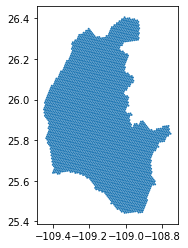

In [31]:
res.plot()

In [32]:
res.loc[(res.CVEGEO.isna())&(res['type']=='urban')]

,hex_id_8,CVEGEO,NOMGEO,city,geometry,type


In [33]:
res.loc[((res.CVEGEO.isna())&(res['type']=='rural'))]

,hex_id_8,CVEGEO,NOMGEO,city,geometry,type
6,884801793dfffff,NaN,NaN,NaN,"POLYGON ((-108.89486 25.47413, -108.89026 25.4...",rural
7,88480ec243fffff,NaN,NaN,NaN,"POLYGON ((-108.97727 25.87802, -108.97265 25.8...",rural
110,88480e0a47fffff,NaN,NaN,NaN,"POLYGON ((-109.10531 26.30791, -109.10069 26.3...",rural
121,88480e831bfffff,NaN,NaN,NaN,"POLYGON ((-109.42329 25.85345, -109.41869 25.8...",rural
134,88480ec081fffff,NaN,NaN,NaN,"POLYGON ((-108.98651 26.00428, -108.98189 26.0...",rural
...,...,...,...,...,...,...
4595,88480edae7fffff,NaN,NaN,NaN,"POLYGON ((-108.82965 25.84861, -108.82503 25.8...",rural
4619,88480ecea9fffff,NaN,NaN,NaN,"POLYGON ((-108.98331 26.11616, -108.97868 26.1...",rural
4659,88480ed0a5fffff,NaN,NaN,NaN,"POLYGON ((-108.96242 25.84802, -108.95781 25.8...",rural
4672,88480e9339fffff,NaN,NaN,NaN,"POLYGON ((-109.40247 25.68881, -109.39788 25.6...",rural


<AxesSubplot: >

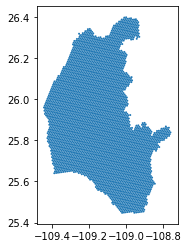

In [34]:
res.loc[~((res.CVEGEO.isna())&(res['type']=='rural'))].plot()

In [36]:
res = res.loc[~((res.CVEGEO.isna())&(res['type']=='rural'))]
res

,hex_id_8,CVEGEO,NOMGEO,city,geometry,type
0,88480ed0b7fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.99111 25.86833, -108.98649 25.8...",rural
1,88480e8345fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.38207 25.81890, -109.37747 25.8...",rural
2,884803a691fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.88832 25.69797, -108.88371 25.7...",rural
3,8848017999fffff,25001,Ahome,Los Mochis,"POLYGON ((-108.97205 25.51228, -108.96745 25.5...",rural
4,88480160b5fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.16142 25.61591, -109.15682 25.6...",rural
...,...,...,...,...,...,...
4714,88480e1001fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.25810 26.13736, -109.25349 26.1...",rural
4715,88480e1a93fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.18991 26.22561, -109.18529 26.2...",rural
4716,88480e1009fffff,25001,Ahome,Los Mochis,"POLYGON ((-109.26190 26.12891, -109.25729 26.1...",rural
4717,8848017abdfffff,25001,Ahome,Los Mochis,"POLYGON ((-109.03483 25.45660, -109.03023 25.4...",rural


In [37]:
res['type'].unique()

array(['rural', 'urban'], dtype=object)

<AxesSubplot: >

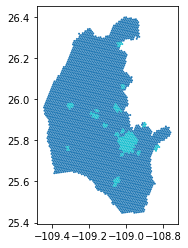

In [38]:
res.plot('type')